# Visualize ART predictions
This notebook presents multiple visualizations of the recommendations produced by ART. Each recommendation consists of a decimal value of CRISPRa spacer length for the genes lgtA, lacY, wbgO, a predicted LNT titer, and a prediction uncertainty. 

Import statements

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import cloudpickle as cpkl

import os
import sys
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append('../art')
sys.path.append('../notebooks')
import auxiliary_functions
import itertools

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Import art

In [2]:
art_file = './output_morerecs_dist0_04/art.cpkl'
with open(art_file, 'rb') as output:
        art = cpkl.load(output)
art.input_vars

['lgtA', 'lacY', 'wbgO']

## Extract recommendation dataframe and add predictions to it

In [3]:
r = art.recommendations
pred_stats = art.l1_learner.post_pred_stats(art.recommendations.iloc[:,:3])
pred_stats
r['pred_var'] = pred_stats[1]
r.head(5)

,lgtA,lacY,wbgO,LNT I,pred_var
0,20.999424,14.362348,20.998313,567.055012,64.549734
1,20.605496,13.327113,20.849797,513.430917,57.294957
2,15.134008,12.722685,20.995260,308.690906,55.044096
3,14.312872,12.779354,20.995260,287.205033,54.797476
4,13.728880,12.606232,20.957532,254.487372,55.180377


## Plot 1: Plotting genes in 3D space, colored by predicted titer

Text(0.5, 0, 'wbgO')

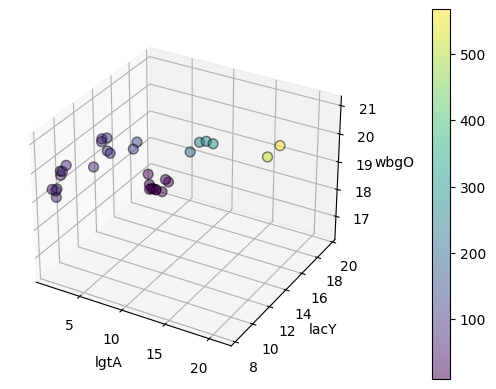

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmhot = plt.get_cmap("hot")

cax = ax.scatter(r['lgtA'], r['lacY'], r['wbgO'], s = 50, c = r['LNT I'], cmap = 'viridis', edgecolor = 'k', alpha = 0.5)
cb = plt.colorbar(cax, pad = 0.15)
ax.set_xlabel('lgtA')
ax.set_ylabel('lacY')
ax.set_zlabel('wbgO')

## Plot 2: Pairplot

/tmp/ipykernel_10327/4193265421.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.figure.colorbar(sm)


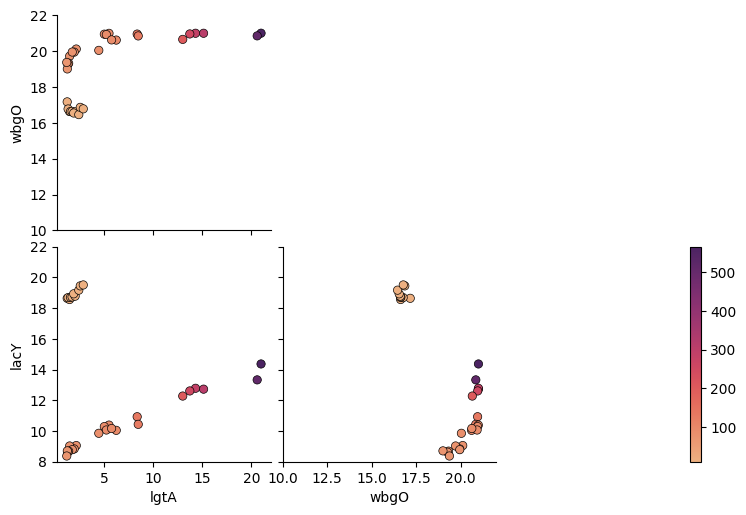

In [5]:
# Create pairplot of bottom right triangle
sns_colormap = 'flare'
fig = sns.pairplot(r[['lgtA', 'wbgO', 'lacY', 'LNT I']], 
                   hue = 'LNT I', corner = True, diag_kind = None,
                  palette = sns_colormap, plot_kws=dict(edgecolor="k"))
fig.savename = './figures_morerecs_dist0_04/rec_pairplot'

# Remove redundant diagonal axes
fig.axes[0][0].set_visible(False)
fig.axes[1][1].set_visible(False)
fig.axes[2][2].set_visible(False)
# Create a scalarmappable for a colorbar
norm = plt.Normalize(r['LNT I'].min(), r['LNT I'].max())
sm = plt.cm.ScalarMappable(cmap = sns_colormap, norm = norm)
sm.set_array([])
#Remove legend and add colorbar
fig._legend.remove()
fig.figure.colorbar(sm)

#Update wbgO axes
ax_lim = [10,22]
fig.axes[1][0].set_ylim(ax_lim)
fig.axes[2][0].set_ylim([8, 22])
fig.axes[2][1].set_xlim(ax_lim)

#Save figure
fig.savefig(fig.savename + '.pdf')
fig.savefig(fig.savename + '.png')

## Plot 3: Scatterplot of each gene with uncertainty

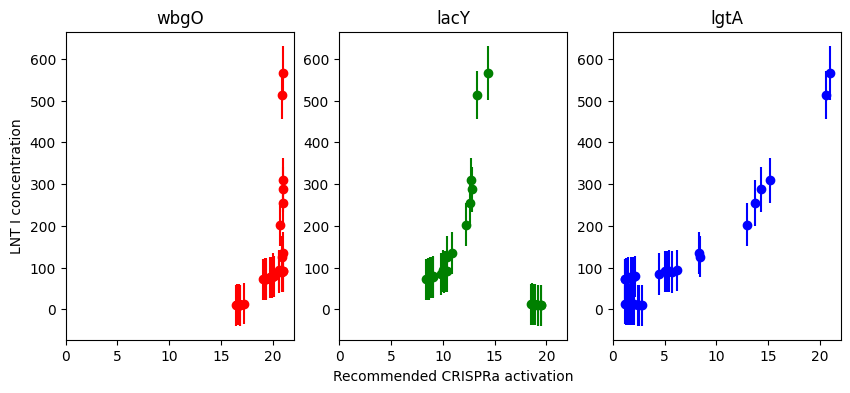

In [6]:
fig, ax = plt.subplots(figsize = (10,4), ncols = 3, nrows = 1)
fig.savename = './figures_morerecs_dist0_04/rec_scatter_indiv_genes'
fields = ['wbgO', 'lacY', 'lgtA']
colors = ['r', 'g', 'b']
for ii, f in enumerate(fields):
    ax[ii].scatter(r[f], r['LNT I'], c = colors[ii])
    ax[ii].errorbar(x = r[f], y = r['LNT I'], yerr = r['pred_var'], fmt = 'none', c = colors[ii])
    ax[ii].set_xlim([0, 22])
    ax[ii].set_title(f)
ax[0].set_ylabel('LNT I concentration')
ax[1].set_xlabel('Recommended CRISPRa activation')
fig.savefig(fig.savename + '.pdf')
fig.savefig(fig.savename + '.png')

Make a melted dataframe to visualize the distribution of each prediction using a swarmplot

In [7]:
r_melt = r.melt(value_vars = ['lgtA', 'lacY', 'wbgO'], id_vars=['LNT I'])
display(r_melt)

,LNT I,variable,value
0,567.055012,lgtA,20.999424
1,513.430917,lgtA,20.605496
2,308.690906,lgtA,15.134008
3,287.205033,lgtA,14.312872
4,254.487372,lgtA,13.728880
...,...,...,...
91,11.503978,wbgO,16.609650
92,10.587709,wbgO,16.547098
93,9.998447,wbgO,16.457115
94,9.966525,wbgO,16.861695


## Plot 4: Swarmplot of each gene recommendation colored by titer

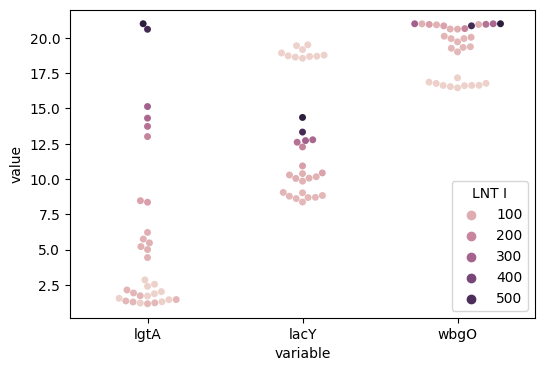

In [8]:
fig, ax = plt.subplots(figsize = (6,4))
sns.swarmplot(r_melt, x = 'variable', y = 'value', hue = 'LNT I')
fig.savename = './figures_morerecs_dist0_04/rec_swarm_by_gene'
fig.savefig(fig.savename + '.pdf')
fig.savefig(fig.savename + '.png')